# Oscillatory Interference Grid Optimization

In [1]:
from matplotlib import pyplot as plt
#from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import math

#Fix random seeds for reproducibility
import numpy as np
import random

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.use_deterministic_algorithms(True)

In [2]:
class OscillatoryGridCell2D(nn.Module):
    def __init__(self, *args, symmetric_scaling=False, randomize=True, fix_grid=True, n_oscillators=3, dtype=torch.float32, frequency_initializer=lambda x: nn.init.uniform_(x, 0, 2), device="cpu", **kwargs):
        super().__init__(*args, **kwargs)

        self.device = device
        self.dtype = dtype

        self.phase_shift = self._init_param([0, 0], lambda x: nn.init.uniform_(x, 0, 1) if randomize else x, requires_grad=True)
        if symmetric_scaling:
            self.frequency = self._init_param(1, frequency_initializer if randomize else lambda x: x, requires_grad=True)
        else:
            self.frequency = self._init_param([1, 1], frequency_initializer if randomize else lambda x: x, requires_grad=True)

        assert n_oscillators > 0, "Number of oscillatory functions must be greater than 0"
        self.n_oscillators = n_oscillators
        if fix_grid:
            if self.n_oscillators == 3:
                # Hexagonal grid
                self.common_rotation = self._init_param(0, lambda x: nn.init.uniform_(x, 0, torch.pi / 3) if randomize else x, requires_grad=True)
                self.rotations = self._init_param([0, torch.pi/3, -torch.pi/3], lambda x: x, requires_grad=False)
            elif self.n_oscillators == 2:
                # Rectangular grid
                self.common_rotation = self._init_param(0, lambda x: nn.init.uniform_(x, 0, torch.pi / 2) if randomize else x, requires_grad=True)
                self.rotations = self._init_param([0, torch.pi/2], lambda x: x, requires_grad=False)
            else:
                raise NotImplementedError("Only Rectangular and Hexagonal grids can be fixed")
            assert self.rotations.shape[0] == self.n_oscillators, "Number of oscillators must match the number of rotations"
        else:
            self.common_rotation = self._init_param(0, lambda x: x, requires_grad=False)
            self.rotations = self._init_param(np.zeros(self.n_oscillators), lambda x: nn.init.uniform_(x, 0, torch.pi) if randomize else x, requires_grad=True)


    def forward(self, position):
        """Encode a point on a cartesian 2D plane to a hexagonal grid cell activation.
            position.shape = (..., 2)
        """
        # We scale only the coordinates to keep the shift in the [0, 1] range
        position = self.frequency * position - self.phase_shift

        # We compute the activation of each oscillator
        activation = torch.stack([self._oscillator(self._rotate(position, self.rotations[i] + self.common_rotation)) for i in range(self.n_oscillators)], dim=-1).sum(dim=-1)

        #TODO: Add normalization (we know it only works for 1, 2 or 3 oscillators)
        #TODO: Add non-linearity like in the paper
        return activation
    
    def _oscillator(self, position):
        return torch.cos(2 * torch.pi * position)

    def _rotate(self, X, alpha):
        """ Rotate given vectors by alpha radians.
        X.shape = (..., 2)
        """
        if len(X.shape) > 1:
            return torch.concat([torch.cos(alpha) * X[..., 0] + torch.sin(alpha) * X[..., 1]], dim=-1)
        else:
            return torch.cos(alpha) * X[0] + torch.sin(alpha) * X[1]
        # We may do it like this, but it may be slower:
        #return X @ torch.tensor([torch.cos(alpha), torch.sin(alpha)], dtype=self.dtype, device=self.device)

    def _init_param(self, default_value, init_function, requires_grad=True):
        param = torch.tensor(default_value, dtype=self.dtype, device=self.device)
        init_function(param)
        param = nn.Parameter(param, requires_grad=requires_grad)
        return param

In [3]:
class GridCell2DArray(nn.Module):
    def __init__(self, n_neurons, *args, symmetric_scaling=False, fix_grid=True, n_oscillators=3, dtype=torch.float32, device="cpu", **kwargs):
        super().__init__(*args, **kwargs)

        self.device = device
        self.dtype = dtype

        assert n_neurons > 0, "Number of neurons must be positive."
        self.neurons = nn.ModuleList([
            OscillatoryGridCell2D(symmetric_scaling=symmetric_scaling, fix_grid=fix_grid, n_oscillators=n_oscillators, dtype=dtype, device=device)
            for _ in range(n_neurons)
        ])

    def forward(self, X):
        """Encode a point on a cartesian 2D plane to a vector of grid cell neuron activations."""
        return torch.stack([cell(X) for cell in self.neurons], dim=-1).squeeze(dim=0)

In [4]:
default_grid_cell = OscillatoryGridCell2D(symmetric_scaling=True, randomize=False, fix_grid=True, n_oscillators=3, dtype=torch.float32, device=device)

In [5]:
positions = torch.tensor([
    [[0, 0  ], [0.5, 0  ], [1, 0  ]],
    [[0, 0.5], [0.5, 0.5], [1, 0.5]],
    [[0, 1  ], [0.5, 1  ], [1, 1  ]],
], dtype=torch.float32, device=device)

default_grid_cell(positions)

tensor([[ 3.0000, -1.0000, -1.0000],
        [-0.8254, -1.0000,  2.8254],
        [ 2.3323, -1.0000, -0.3323]], grad_fn=<SumBackward1>)

In [6]:
N = 1001
x_min, x_max = -1, 1
y_min, y_max = -1, 1

x_coords = torch.linspace(x_min, x_max, N, dtype=torch.float32, device=device)
y_coords = torch.linspace(y_min, y_max, N, dtype=torch.float32, device=device)

positions = torch.stack(torch.meshgrid(x_coords, y_coords, indexing="xy"), dim=-1)

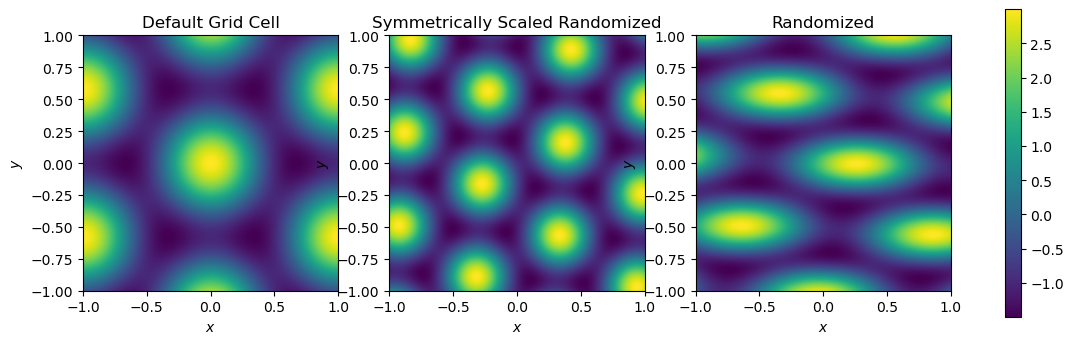

In [7]:
randomized_grid_cell = OscillatoryGridCell2D(symmetric_scaling=False, randomize=True, fix_grid=True, n_oscillators=3, dtype=torch.float32, device=device)
symmetric_randomized_grid_cell = OscillatoryGridCell2D(symmetric_scaling=True, randomize=True, fix_grid=True, n_oscillators=3, dtype=torch.float32, device=device)

fig, axes = plt.subplots(ncols=3, figsize=(14, 4))

axes[0].imshow(default_grid_cell(positions).detach().numpy(), origin="lower", extent=[x_min, x_max, y_min, y_max])
axes[0].set_title(r"Default Grid Cell")
axes[0].set_xlabel(r"$x$")
axes[0].set_ylabel(r"$y$")
axes[0].set_aspect("equal")

im = axes[1].imshow(symmetric_randomized_grid_cell(positions).detach().numpy(), origin="lower", extent=[x_min, x_max, y_min, y_max])
axes[1].set_title(r"Symmetrically Scaled Randomized")
axes[1].set_xlabel(r"$x$")
axes[1].set_ylabel(r"$y$")
axes[1].set_aspect("equal")

im = axes[2].imshow(randomized_grid_cell(positions).detach().numpy(), origin="lower", extent=[x_min, x_max, y_min, y_max])
axes[2].set_title(r"Randomized")
axes[2].set_xlabel(r"$x$")
axes[2].set_ylabel(r"$y$")
axes[2].set_aspect("equal")


cbar = fig.colorbar(im, ax=axes.ravel().tolist())

plt.show();

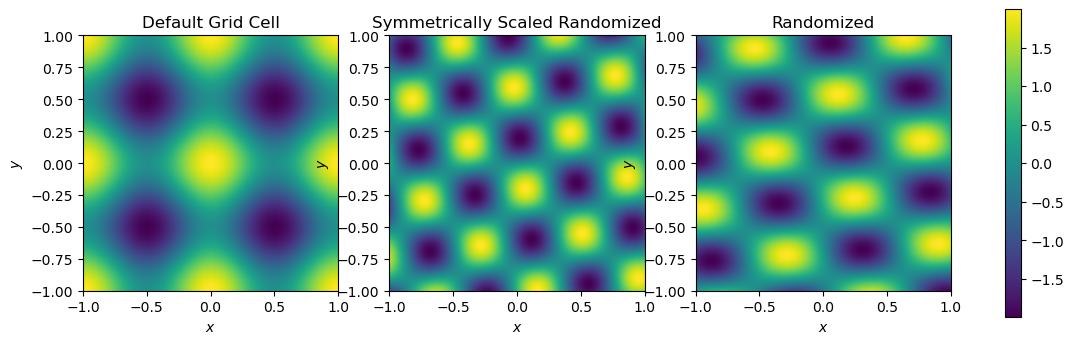

In [8]:
default_grid_cell = OscillatoryGridCell2D(symmetric_scaling=True, randomize=False, fix_grid=True, n_oscillators=2, dtype=torch.float32, device=device)
randomized_grid_cell = OscillatoryGridCell2D(symmetric_scaling=False, randomize=True, fix_grid=True, n_oscillators=2, dtype=torch.float32, device=device)
symmetric_randomized_grid_cell = OscillatoryGridCell2D(symmetric_scaling=True, randomize=True, fix_grid=True, n_oscillators=2, dtype=torch.float32, device=device)

fig, axes = plt.subplots(ncols=3, figsize=(14, 4))

axes[0].imshow(default_grid_cell(positions).detach().numpy(), origin="lower", extent=[x_min, x_max, y_min, y_max])
axes[0].set_title(r"Default Grid Cell")
axes[0].set_xlabel(r"$x$")
axes[0].set_ylabel(r"$y$")
axes[0].set_aspect("equal")

im = axes[1].imshow(symmetric_randomized_grid_cell(positions).detach().numpy(), origin="lower", extent=[x_min, x_max, y_min, y_max])
axes[1].set_title(r"Symmetrically Scaled Randomized")
axes[1].set_xlabel(r"$x$")
axes[1].set_ylabel(r"$y$")
axes[1].set_aspect("equal")

im = axes[2].imshow(randomized_grid_cell(positions).detach().numpy(), origin="lower", extent=[x_min, x_max, y_min, y_max])
axes[2].set_title(r"Randomized")
axes[2].set_xlabel(r"$x$")
axes[2].set_ylabel(r"$y$")
axes[2].set_aspect("equal")


cbar = fig.colorbar(im, ax=axes.ravel().tolist())

plt.show();

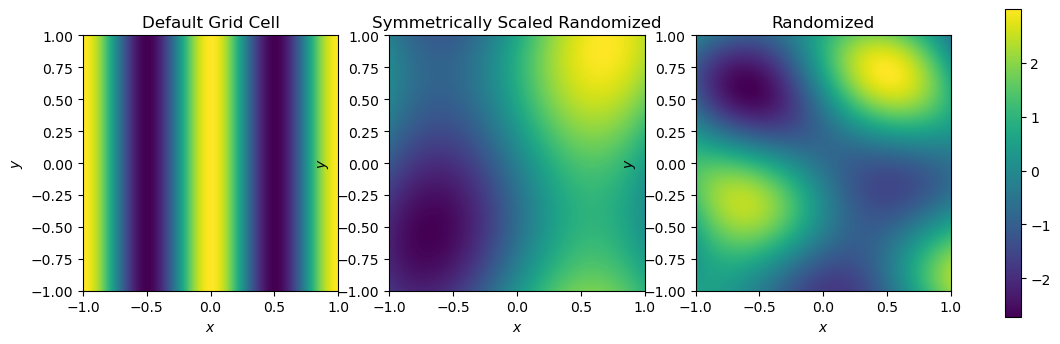

In [9]:
default_grid_cell = OscillatoryGridCell2D(symmetric_scaling=True, randomize=False, fix_grid=False, n_oscillators=3, dtype=torch.float32, device=device)
randomized_grid_cell = OscillatoryGridCell2D(symmetric_scaling=False, randomize=True, fix_grid=False, n_oscillators=3, dtype=torch.float32, device=device)
symmetric_randomized_grid_cell = OscillatoryGridCell2D(symmetric_scaling=True, randomize=True, fix_grid=False, n_oscillators=3, dtype=torch.float32, device=device)

fig, axes = plt.subplots(ncols=3, figsize=(14, 4))

axes[0].imshow(default_grid_cell(positions).detach().numpy(), origin="lower", extent=[x_min, x_max, y_min, y_max])
axes[0].set_title(r"Default Grid Cell")
axes[0].set_xlabel(r"$x$")
axes[0].set_ylabel(r"$y$")
axes[0].set_aspect("equal")

im = axes[1].imshow(symmetric_randomized_grid_cell(positions).detach().numpy(), origin="lower", extent=[x_min, x_max, y_min, y_max])
axes[1].set_title(r"Symmetrically Scaled Randomized")
axes[1].set_xlabel(r"$x$")
axes[1].set_ylabel(r"$y$")
axes[1].set_aspect("equal")

im = axes[2].imshow(randomized_grid_cell(positions).detach().numpy(), origin="lower", extent=[x_min, x_max, y_min, y_max])
axes[2].set_title(r"Randomized")
axes[2].set_xlabel(r"$x$")
axes[2].set_ylabel(r"$y$")
axes[2].set_aspect("equal")


cbar = fig.colorbar(im, ax=axes.ravel().tolist())

plt.show();

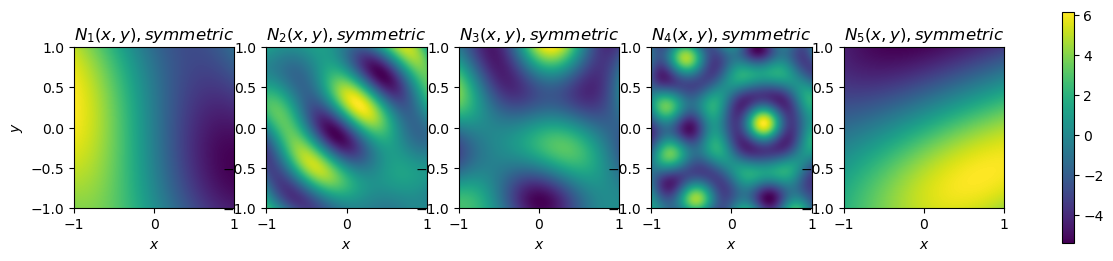

In [10]:
grid_cell_array = GridCell2DArray(5, symmetric_scaling=False, fix_grid=False, n_oscillators=10, dtype=torch.float32, device=device)
symmetric_grid_cell_array = GridCell2DArray(5, symmetric_scaling=True, fix_grid=False, n_oscillators=10, dtype=torch.float32, device=device)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))

# for i, neuron in enumerate(grid_cell_array.neurons):
#     im = axes[0, i].imshow(neuron(positions).detach().numpy(), origin="lower", extent=[x_min, x_max, y_min, y_max])
#     axes[0, i].set_title(r"$N_{}\left(x, y\right), asymmetric$".format(i + 1))
#     axes[0, i].set_xlabel(r"$x$")
#     if i == 0:
#         axes[0, i].set_ylabel(r"$y$")

for i, neuron in enumerate(symmetric_grid_cell_array.neurons):
    im = axes[i].imshow(neuron(positions).detach().numpy(), origin="lower", extent=[x_min, x_max, y_min, y_max])
    axes[i].set_title(r"$N_{}\left(x, y\right), symmetric$".format(i + 1))
    axes[i].set_xlabel(r"$x$")
    if i == 0:
        axes[i].set_ylabel(r"$y$")

cbar = fig.colorbar(im, ax=axes.ravel().tolist())

plt.show()

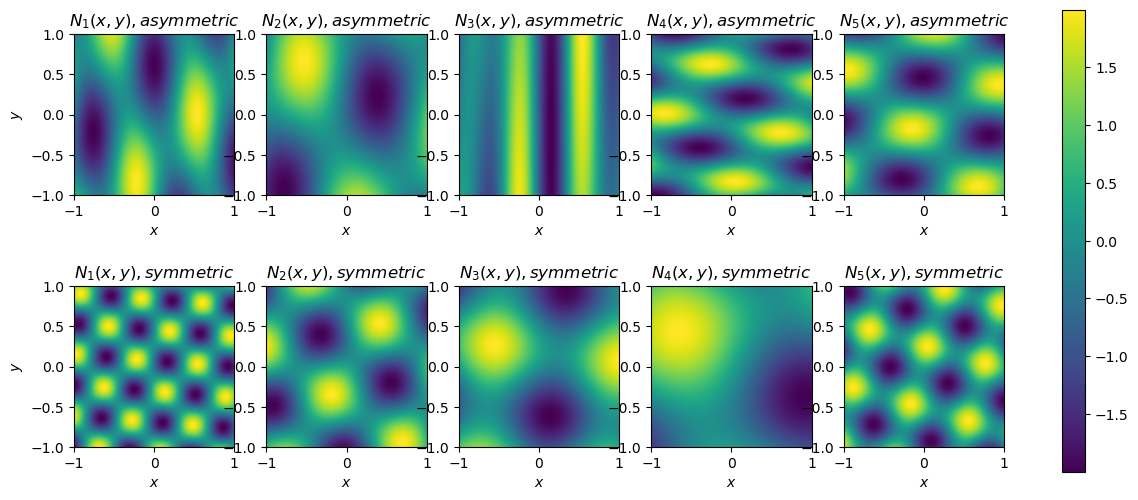

In [11]:
grid_cell_array = GridCell2DArray(5, symmetric_scaling=False, fix_grid=True, n_oscillators=2, dtype=torch.float32, device=device)
symmetric_grid_cell_array = GridCell2DArray(5, symmetric_scaling=True, fix_grid=True, n_oscillators=2, dtype=torch.float32, device=device)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))

for i, neuron in enumerate(grid_cell_array.neurons):
    im = axes[0, i].imshow(neuron(positions).detach().numpy(), origin="lower", extent=[x_min, x_max, y_min, y_max])
    axes[0, i].set_title(r"$N_{}\left(x, y\right), asymmetric$".format(i + 1))
    axes[0, i].set_xlabel(r"$x$")
    if i == 0:
        axes[0, i].set_ylabel(r"$y$")

for i, neuron in enumerate(symmetric_grid_cell_array.neurons):
    im = axes[1, i].imshow(neuron(positions).detach().numpy(), origin="lower", extent=[x_min, x_max, y_min, y_max])
    axes[1, i].set_title(r"$N_{}\left(x, y\right), symmetric$".format(i + 1))
    axes[1, i].set_xlabel(r"$x$")
    if i == 0:
        axes[1, i].set_ylabel(r"$y$")

cbar = fig.colorbar(im, ax=axes.ravel().tolist())

plt.show()

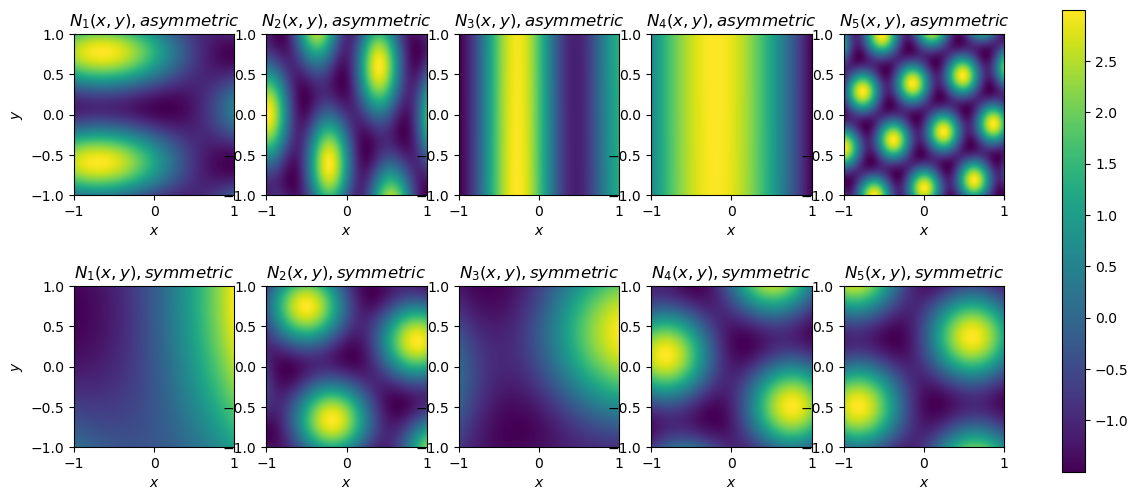

In [12]:
grid_cell_array = GridCell2DArray(5, symmetric_scaling=False, fix_grid=True, n_oscillators=3, dtype=torch.float32, device=device)
symmetric_grid_cell_array = GridCell2DArray(5, symmetric_scaling=True, fix_grid=True, n_oscillators=3, dtype=torch.float32, device=device)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))

for i, neuron in enumerate(grid_cell_array.neurons):
    im = axes[0, i].imshow(neuron(positions).detach().numpy(), origin="lower", extent=[x_min, x_max, y_min, y_max])
    axes[0, i].set_title(r"$N_{}\left(x, y\right), asymmetric$".format(i + 1))
    axes[0, i].set_xlabel(r"$x$")
    if i == 0:
        axes[0, i].set_ylabel(r"$y$")

for i, neuron in enumerate(symmetric_grid_cell_array.neurons):
    im = axes[1, i].imshow(neuron(positions).detach().numpy(), origin="lower", extent=[x_min, x_max, y_min, y_max])
    axes[1, i].set_title(r"$N_{}\left(x, y\right), symmetric$".format(i + 1))
    axes[1, i].set_xlabel(r"$x$")
    if i == 0:
        axes[1, i].set_ylabel(r"$y$")

cbar = fig.colorbar(im, ax=axes.ravel().tolist())

plt.show()

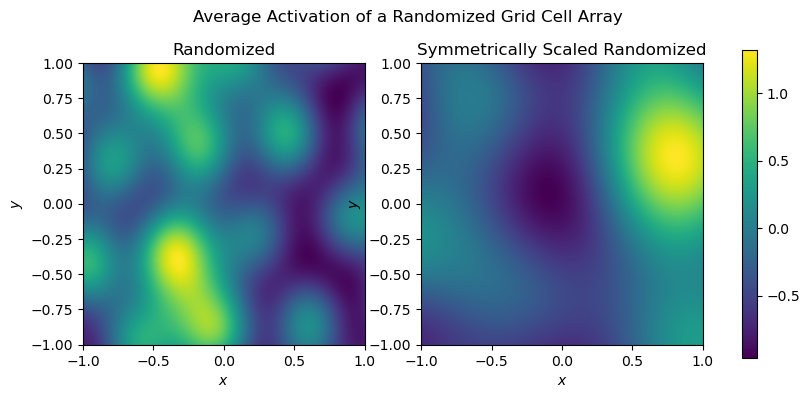

In [13]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

axes[0].imshow(grid_cell_array(positions).mean(axis=-1).detach().numpy(), origin="lower", extent=[x_min, x_max, y_min, y_max])
axes[0].set_title(r"Randomized")
axes[0].set_xlabel(r"$x$")
axes[0].set_ylabel(r"$y$")
axes[0].set_aspect("equal")

im = axes[1].imshow(symmetric_grid_cell_array(positions).mean(axis=-1).detach().numpy(), origin="lower", extent=[x_min, x_max, y_min, y_max])
axes[1].set_title(r"Symmetrically Scaled Randomized")
axes[1].set_xlabel(r"$x$")
axes[1].set_ylabel(r"$y$")
axes[1].set_aspect("equal")

cbar = fig.colorbar(im, ax=axes.ravel().tolist())

plt.suptitle("Average Activation of a Randomized Grid Cell Array", x=0.45)

plt.show();

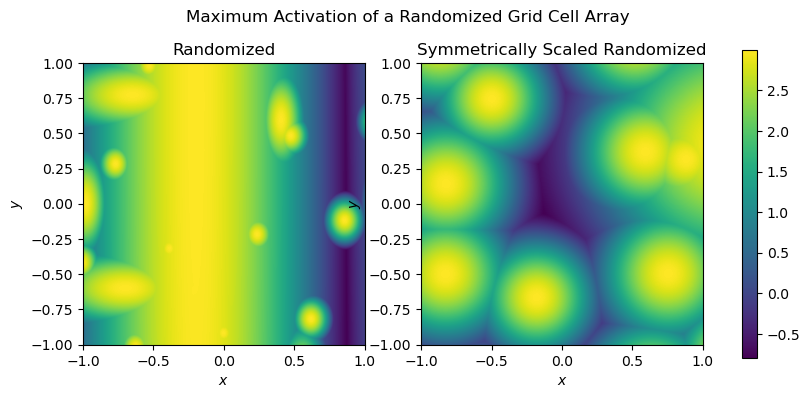

In [14]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

axes[0].imshow(grid_cell_array(positions).max(axis=-1).values.detach().numpy(), origin="lower", extent=[x_min, x_max, y_min, y_max])
axes[0].set_title(r"Randomized")
axes[0].set_xlabel(r"$x$")
axes[0].set_ylabel(r"$y$")
axes[0].set_aspect("equal")

im = axes[1].imshow(symmetric_grid_cell_array(positions).max(axis=-1).values.detach().numpy(), origin="lower", extent=[x_min, x_max, y_min, y_max])
axes[1].set_title(r"Symmetrically Scaled Randomized")
axes[1].set_xlabel(r"$x$")
axes[1].set_ylabel(r"$y$")
axes[1].set_aspect("equal")

cbar = fig.colorbar(im, ax=axes.ravel().tolist())

plt.suptitle("Maximum Activation of a Randomized Grid Cell Array", x=0.45)

plt.show();

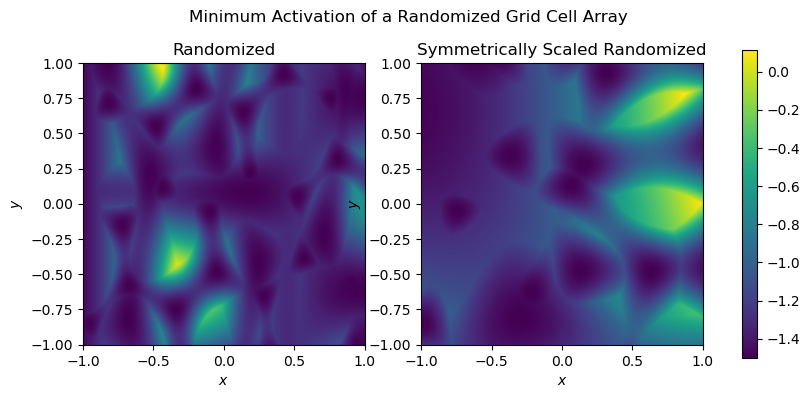

In [15]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

axes[0].imshow(grid_cell_array(positions).min(axis=-1).values.detach().numpy(), origin="lower", extent=[x_min, x_max, y_min, y_max])
axes[0].set_title(r"Randomized")
axes[0].set_xlabel(r"$x$")
axes[0].set_ylabel(r"$y$")
axes[0].set_aspect("equal")

im = axes[1].imshow(symmetric_grid_cell_array(positions).min(axis=-1).values.detach().numpy(), origin="lower", extent=[x_min, x_max, y_min, y_max])
axes[1].set_title(r"Symmetrically Scaled Randomized")
axes[1].set_xlabel(r"$x$")
axes[1].set_ylabel(r"$y$")
axes[1].set_aspect("equal")

cbar = fig.colorbar(im, ax=axes.ravel().tolist())

plt.suptitle("Minimum Activation of a Randomized Grid Cell Array", x=0.45)

plt.show();

In [16]:
class LinearDecoder(nn.Module):
    def __init__(self, grid_cell_array, *args, weighted=True, weight_normalization=None, probability_normalization="softmax", dtype=torch.float32, device="cpu", **kwargs):
        super().__init__(*args, **kwargs)

        self.device = device
        self.dtype = dtype

        self.n_neurons = len(grid_cell_array.neurons)
        
        self.grid_cell_array = grid_cell_array

        # We don't need need bias because we will be inferring the predicted position from the maximum activation value
        weights_ = torch.ones(self.n_neurons, dtype=dtype, device=device)
        if weighted:
            nn.init.normal_(weights_, 0, 1)
        self.weights_ = nn.Parameter(weights_, requires_grad=weighted)
        if weight_normalization is None:
            self.normalize_weights = lambda x: x
        elif weight_normalization == "softmax":
            self.normalize_weights = nn.Softmax(dim=-1)
        elif weight_normalization == "linear":
            self.normalize_weights = lambda x: x / torch.sum(x)
        elif weight_normalization == "squared":
            # The squared normalization is useful to enforce the weights to be positive
            self.normalize_weights = lambda x: x ** 2 / torch.sum(x ** 2)
        else:
            raise ValueError("Invalid weight normalization method.")
        
        if probability_normalization is None:
            self.normalize_probabilities = lambda x: x
        elif probability_normalization == "softmax":
            self.normalize_probabilities = nn.Softmax(dim=-1)
        elif probability_normalization == "linear":
            self.normalize_probabilities = lambda x: x / torch.sum(x)
        elif probability_normalization == "squared":
            self.normalize_probabilities = lambda x: x ** 2 / torch.sum(x ** 2)
        else:
            raise ValueError("Invalid probability normalization method.")
    
    def forward(self, true_activations, position_estimates):
        """Decode the neuron representation"""
        assert (true_activations.shape[-1] == self.n_neurons), "The number of neurons in the grid cell array must match the number of neurons used the true activations."
        if len(true_activations.shape) == 1 or len(true_activations.shape) > 2:
            true_activations = true_activations.reshape(-1, self.n_neurons)

        if len(position_estimates.shape) == 1:
            position_estimates = position_estimates.reshape(1, -1)
        elif len(position_estimates.shape) > 2:
            position_estimates = position_estimates.reshape(-1, position_estimates.shape[-1])

        # 1. Compute the activation for possible X estimations
        estimated_activations = self.grid_cell_array(position_estimates)

        # 2. Multiply it by the activations for the true positions (it will discriminate against the other positions)
        # TODO: Optimize this step using better vectorization technique
        if len(estimated_activations.shape) == 1:
            estimated_activations = estimated_activations.reshape(1, -1)
        discriminated_activations = (estimated_activations.expand(true_activations.shape[0], -1, -1).transpose(0, 1) * true_activations).transpose(0, 1)
        # 3. Compute the weighted sum using the decoder weights (the decoder will consider some neurons more "valuable" than others)
        decoded_activations = discriminated_activations @ self.weights()
        # Apply softmax to get the position probability distribution estimate
        position_probabilities = self.normalize_probabilities(decoded_activations.reshape(true_activations.shape[0], -1))
        # 4. Find the position expectations by computing the weighted sum of the position estimations' probabilities
        position_expectations = position_probabilities @ position_estimates
        # Normalize in case the probabilities don't sum up to 1
        position_expectations /= position_probabilities.sum(dim=-1, keepdim=True)
        most_probable_positions = position_estimates[position_probabilities.argmax(dim=-1)]
        return position_probabilities, position_expectations, most_probable_positions
    
    def weights(self):
        # Note that we may use the normalization to force the weights to sum up to 1
        return self.normalize_weights(self.weights_)

In [17]:
decoder = LinearDecoder(grid_cell_array, weighted=False, weight_normalization=None, probability_normalization="softmax", dtype=torch.float32, device=device)
decoder.weights()

Parameter containing:
tensor([1., 1., 1., 1., 1.])

In [18]:
true_x = torch.tensor([0.5, 0.5], dtype=torch.float32, device=device)
true_activations = grid_cell_array(true_x)
true_activations

tensor([-0.8901,  2.3881, -1.0185,  1.8187,  2.9184],
       grad_fn=<SqueezeBackward1>)

In [19]:
positions = torch.tensor([0.5, 0.5], dtype=torch.float32, device=device)

position_probabilities, position_expectation, most_probable_position = decoder(true_activations, positions)

print((true_activations.reshape(1, -1) ** 2).mean(dim=-1))

position_probabilities, position_expectation, most_probable_position

tensor([3.8716], grad_fn=<MeanBackward1>)


(tensor([[1.]], grad_fn=<SoftmaxBackward0>),
 tensor([[0.5000, 0.5000]], grad_fn=<DivBackward0>),
 tensor([[0.5000, 0.5000]]))

In [20]:
decoder = LinearDecoder(grid_cell_array, dtype=torch.float32, device=device, weighted=True)
decoder.weights()

Parameter containing:
tensor([ 0.0110,  0.1447,  1.2818, -1.5952, -1.0648], requires_grad=True)

In [21]:
positions = torch.tensor([
    [0, 0.5  ], [0.5, 0.5  ], [1, 0.5  ],
], dtype=torch.float32, device=device)

decoder(true_activations, positions)

(tensor([[0.0061, 0.0091, 0.9849]], grad_fn=<SoftmaxBackward0>),
 tensor([[0.9894, 0.5000]], grad_fn=<DivBackward0>),
 tensor([[1.0000, 0.5000]]))

In [22]:
positions = torch.tensor([
    [[0, 0  ], [0.5, 0  ], [1, 0  ]],
    [[0, 0.5], [0.5, 0.5], [1, 0.5]],
    [[0, 1  ], [0.5, 1  ], [1, 1  ]],
], dtype=torch.float32, device=device)

decoder(true_activations, positions)

(tensor([[9.6777e-05, 1.5727e-01, 3.0579e-03, 3.8598e-07, 5.7496e-07, 6.2521e-05,
          1.1446e-08, 5.0315e-02, 7.8919e-01]], grad_fn=<SoftmaxBackward0>),
 tensor([[0.8961, 0.8395]], grad_fn=<DivBackward0>),
 tensor([[1., 1.]]))

In [23]:
true_x = torch.tensor([
    [0  , 0  ],
    [0.5, 0.5],
], dtype=torch.float32, device=device)

true_activations = grid_cell_array(true_x)
true_activations

tensor([[-1.3523, -0.8095,  1.3951,  2.8929, -1.1020],
        [-0.8901,  2.3881, -1.0185,  1.8187,  2.9184]],
       grad_fn=<SqueezeBackward1>)

In [24]:
decoder(true_activations, positions)

(tensor([[1.9473e-07, 2.4360e-07, 1.7729e-01, 1.4616e-06, 2.8253e-05, 7.9929e-01,
          5.4212e-06, 3.8097e-07, 2.3384e-02],
         [9.6777e-05, 1.5727e-01, 3.0579e-03, 3.8598e-07, 5.7496e-07, 6.2521e-05,
          1.1446e-08, 5.0315e-02, 7.8919e-01]], grad_fn=<SoftmaxBackward0>),
 tensor([[1.0000, 0.4230],
         [0.8961, 0.8395]], grad_fn=<DivBackward0>),
 tensor([[1.0000, 0.5000],
         [1.0000, 1.0000]]))

In [25]:
grid_cell_array = GridCell2DArray(5, symmetric_scaling=False, fix_grid=True, n_oscillators=3, dtype=torch.float32, device=device)
decoder = LinearDecoder(grid_cell_array, dtype=torch.float32, device=device, weighted=True)

N = 1001
x_min, x_max = -1, 1
y_min, y_max = -1, 1

x_coords = torch.linspace(x_min, x_max, N, dtype=torch.float32, device=device)
y_coords = torch.linspace(y_min, y_max, N, dtype=torch.float32, device=device)

positions = torch.stack(torch.meshgrid(x_coords, y_coords, indexing="xy"), dim=-1)

true_x = torch.tensor([
    [ 0  ,  0  ],
    [ 0.5,  0.5],
    [ 1  ,  1  ],
    [-1  , -1  ]
], dtype=torch.float32, device=device)

true_activations = grid_cell_array(true_x)
position_probabilities, position_expectations, most_probable_positions = decoder(true_activations, positions)
print(position_probabilities.shape)
print(position_expectations)
print(most_probable_positions)

torch.Size([4, 1002001])
tensor([[-0.2272,  0.3763],
        [ 0.2035, -0.5461],
        [-0.1413,  0.4244],
        [ 0.4957, -0.5978]], grad_fn=<DivBackward0>)
tensor([[-0.4300,  0.6060],
        [-0.9940, -1.0000],
        [ 0.2340,  0.6880],
        [ 0.5420, -0.7460]])


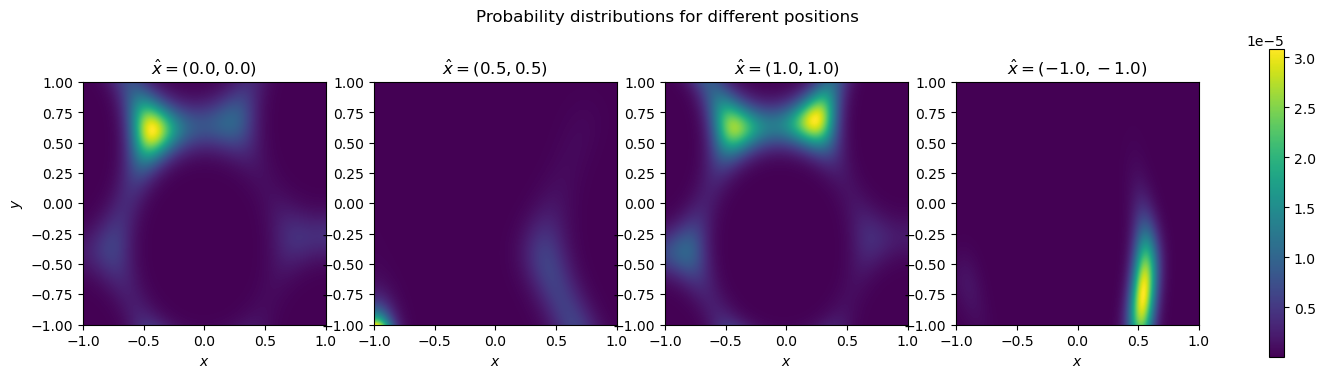

In [26]:
fig, axes = plt.subplots(ncols=true_x.shape[0], figsize=(true_x.shape[0] * 4 + 2, 4))

for i in range(true_x.shape[0]):
    im = axes[i].imshow(position_probabilities[i].reshape(N, N).detach().numpy(), origin="lower", extent=[x_min, x_max, y_min, y_max])
    axes[i].set_title(r"$\hat{{x}} = \left({:.1f}, {:.1f}\right)$".format(true_x[i, 0], true_x[i, 1]))
    axes[i].set_xlabel(r"$x$")
    if i == 0:
        axes[i].set_ylabel(r"$y$")
    axes[i].set_aspect("equal")

cbar = fig.colorbar(im, ax=axes.ravel().tolist())

plt.suptitle("Probability distributions for different positions", x=0.45)

plt.show();

In [27]:
def train(*,
    # Grid Cell Array Parameters
    n_neurons=5,
    symmetric_scaling=True,
    fix_grid=True,
    n_oscillators=3,
    # Decoder Parameters
    weighted_decoder=True,
    weight_normalization=None,
    probability_normalization="softmax",
    # Training Data
    x_min=-1,
    x_max=1,
    y_min=-1,
    y_max=1,
    n_positions=1024, # better to be a square number
    # Test Data
    test_size=0.2,
    # Validation Domain
    validate=True,
    x_val_min=1,
    x_val_max=3,
    y_val_min=1,
    y_val_max=3,
    n_val_positions=100, # better to be a square number
    # Training Parameters
    max_epochs=100,
    target_loss=0.01,
    batch_size=10,
    optimizer="adam",
    learning_rate=0.01,
    loss_functions=None,

    random_seed=None,
    verbose=True,
    dtype=torch.float32,
    device="cpu",
):
    if random_seed is not None:
        random.seed(random_seed)
        np.random.seed(random_seed)
        torch.manual_seed(random_seed)
        torch.use_deterministic_algorithms(True)
        

    # Define the training domain
    x_coords = torch.linspace(x_min, x_max, int(math.sqrt(n_positions)), dtype=torch.float32, device=device)
    y_coords = torch.linspace(y_min, y_max, int(math.sqrt(n_positions)), dtype=torch.float32, device=device)

    positions = torch.stack(torch.meshgrid(x_coords, y_coords, indexing="xy"), dim=-1).reshape(-1, 2)
    #torch.nn.init.uniform_(positions, x_min, x_max)

    # Split the training and test data
    #train_positions, test_positions = train_test_split(positions, test_size=test_size, shuffle=True, random_state=random_seed)
    random_indices = torch.randperm(positions.shape[0], device=device)
    if test_size < 1:
        test_size = int(test_size * positions.shape[0])
    train_positions = positions[random_indices[:-test_size]]
    test_positions = positions[random_indices[-test_size:]]

    # Define the validation domain
    x_val_coords = torch.linspace(x_val_min, x_val_max, int(math.sqrt(n_val_positions)), dtype=torch.float32, device=device)
    y_val_coords = torch.linspace(y_val_min, y_val_max, int(math.sqrt(n_val_positions)), dtype=torch.float32, device=device)

    val_positions = torch.stack(torch.meshgrid(x_val_coords, y_val_coords, indexing="xy"), dim=-1).reshape(-1, 2)

    # Define the grid cell array and the decoder
    grid_cell_array = GridCell2DArray(
        n_neurons,
        symmetric_scaling=symmetric_scaling,
        fix_grid=fix_grid,
        n_oscillators=n_oscillators,
        dtype=dtype,
        device=device,
    )
    decoder = LinearDecoder(
        grid_cell_array,
        weighted=weighted_decoder,
        weight_normalization=weight_normalization,
        probability_normalization=probability_normalization,
        dtype=dtype,
        device=device,
    )

    # Define the optimizer
    if optimizer == "adam":
        optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    elif optimizer == "sgd":
        optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    else:
        raise ValueError("Invalid optimizer.")
    
    if loss_functions is None:
        loss_functions = ["mse", "variance", "negative_log_probability", "decoder_weight_regularization"]
    else:
        for loss in loss_functions:
            if loss not in ["mse", "variance", "negative_log_probability", "decoder_weight_regularization"]:
                raise ValueError("Invalid loss function.")
    
    test_losses = []
    model_converged = False
    for epoch in range(max_epochs):
        # Generate random positions for the epoch
        # TODO: Use DataSet and DataLoader
        train_positions = train_positions[torch.randperm(train_positions.shape[0], device=device)]
        for i in range(0, n_positions - test_size, batch_size):
            optimizer.zero_grad()

            batch_positions = train_positions[i:i + batch_size]
            true_activations = grid_cell_array(batch_positions)
            position_probabilities, position_expectations, _ = decoder(true_activations, batch_positions)

            loss = 0

            # Distance to the expected value (seems to be the worst)
            # TODO: Use MSE loss from torch.nn
            if "mse" in loss_functions:
                loss += ((position_expectations - batch_positions) ** 2).mean()
            
            # Variance (not the best but adds stability)
            if "variance" in loss_functions:
                # for each position, compute the distance to all other positions
                position_distances = torch.stack([((batch_positions - batch_positions[i]) ** 2).sum(dim=-1) for i in range(batch_positions.shape[0])], dim=1)
                #position_distances = ((batch_positions.expand(batch_size, -1).transpose(0,1) - batch_positions) ** 2).sum(dim=-1)
                loss += (position_distances * position_probabilities).mean()

            # Negative log probability for true positions: 
            if "negative_log_probability" in loss_functions:
                loss -= torch.log(position_probabilities.diagonal()).sum()

            # Regularize agaist decoder weight difference:
            if "decoder_weight_regularization" in loss_functions:
                loss += (decoder.weights() ** 2).mean()
            
            loss.backward()
            optimizer.step()
        
        with torch.no_grad():
            test_true_activations = grid_cell_array(test_positions)
            _, _, test_most_probable_positions = decoder(test_true_activations, test_positions)
            test_loss = torch.sqrt((test_most_probable_positions - test_positions) ** 2).mean().item()
            test_losses.append(test_loss)
            
            if validate:
                val_true_activations = grid_cell_array(val_positions)
                _, _, val_most_probable_positions = decoder(val_true_activations, val_positions)
                val_loss = torch.sqrt((val_most_probable_positions - val_positions) ** 2).mean().item()
                if verbose:
                    print(f"Epoch {epoch + 1}: Test Loss: {test_loss}, Validation Loss: {val_loss}")
            elif verbose:
                    print(f"Epoch {epoch + 1}: Test Loss: {test_loss}")

            if test_loss < target_loss:
                model_converged = True
                break
        

    return grid_cell_array, decoder, test_losses, model_converged

In [28]:
grid_cell_array, decoder, test_losses, model_converged  = train(
    # Grid Cell Array Parameters
    n_neurons=10,
    symmetric_scaling=True,
    fix_grid=True,
    n_oscillators=3,
    # Decoder Parameters
    weighted_decoder=True,
    weight_normalization=None,
    probability_normalization="softmax",
    # Training Data
    x_min=-1,
    x_max=1,
    y_min=-1,
    y_max=1,
    n_positions=1024, # better to be a square number
    # Test Data
    test_size=0.2,
    # Validation Domain
    validate=True,
    x_val_min=1,
    x_val_max=3,
    y_val_min=1,
    y_val_max=3,
    n_val_positions=100, # better to be a square number
    # Training Parameters
    max_epochs=2500,
    target_loss=0.001,
    batch_size=100,
    optimizer="adam",
    learning_rate=0.0005,
    loss_functions=["variance", "negative_log_probability", "decoder_weight_regularization"],

    random_seed=42,
    verbose=True,
    dtype=torch.float32,
    device=device,
)

print(model_converged)

Epoch 1: Test Loss: 0.7955407500267029, Validation Loss: 0.7833333015441895
Epoch 2: Test Loss: 0.7852624654769897, Validation Loss: 0.7833333015441895
Epoch 3: Test Loss: 0.7849461436271667, Validation Loss: 0.7799999117851257
Epoch 4: Test Loss: 0.7738773226737976, Validation Loss: 0.7866665720939636
Epoch 5: Test Loss: 0.7686590552330017, Validation Loss: 0.7933332920074463
Epoch 6: Test Loss: 0.7602782845497131, Validation Loss: 0.7877777814865112
Epoch 7: Test Loss: 0.7465211749076843, Validation Loss: 0.7744443416595459
Epoch 8: Test Loss: 0.7261226773262024, Validation Loss: 0.7888887524604797
Epoch 9: Test Loss: 0.719165027141571, Validation Loss: 0.7677778005599976
Epoch 10: Test Loss: 0.7209044098854065, Validation Loss: 0.7555555701255798
Epoch 11: Test Loss: 0.6998734474182129, Validation Loss: 0.7488888502120972
Epoch 12: Test Loss: 0.6903857588768005, Validation Loss: 0.7477777600288391
Epoch 13: Test Loss: 0.6763123869895935, Validation Loss: 0.7266666889190674
Epoch 14:

(0.0, 0.7955407500267029)

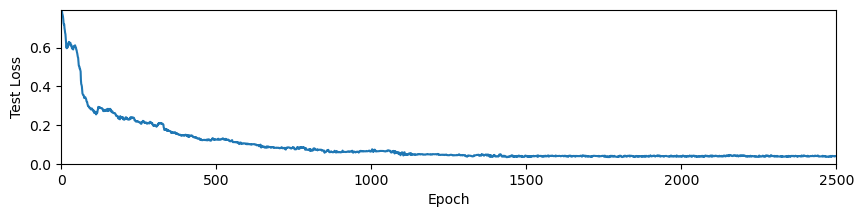

In [29]:
plt.figure(figsize=(10, 2))
plt.plot(test_losses)
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.xlim(0, len(test_losses))
plt.ylim(0, max(test_losses))

In [30]:
N = 1001
x_min, x_max = -1, 1
y_min, y_max = -1, 1

x_coords = torch.linspace(x_min, x_max, N, dtype=torch.float32, device=device)
y_coords = torch.linspace(y_min, y_max, N, dtype=torch.float32, device=device)

positions = torch.stack(torch.meshgrid(x_coords, y_coords, indexing="xy"), dim=-1)

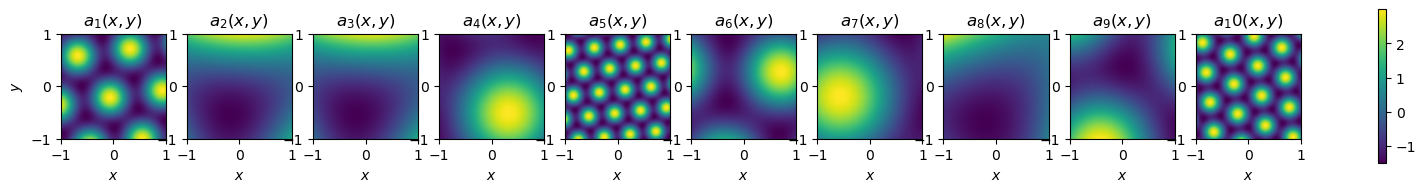

In [31]:
fig, axes = plt.subplots(ncols=10, figsize=(20, 2))

for i, neuron in enumerate(grid_cell_array.neurons[:10]):
    im = axes[i].imshow(neuron(positions).detach().numpy(), origin="lower", extent=[x_min, x_max, y_min, y_max])
    axes[i].set_title(r"$a_{}\left(x, y\right)$".format(i + 1))
    axes[i].set_xlabel(r"$x$")
    if i == 0:
        axes[i].set_ylabel(r"$y$")

cbar = fig.colorbar(im, ax=axes.ravel().tolist())

plt.show()

tensor([[ 0.3104, -0.7076],
        [ 0.6814, -0.4696],
        [ 0.6349, -0.6500],
        [-0.5464,  0.1828]], grad_fn=<DivBackward0>)


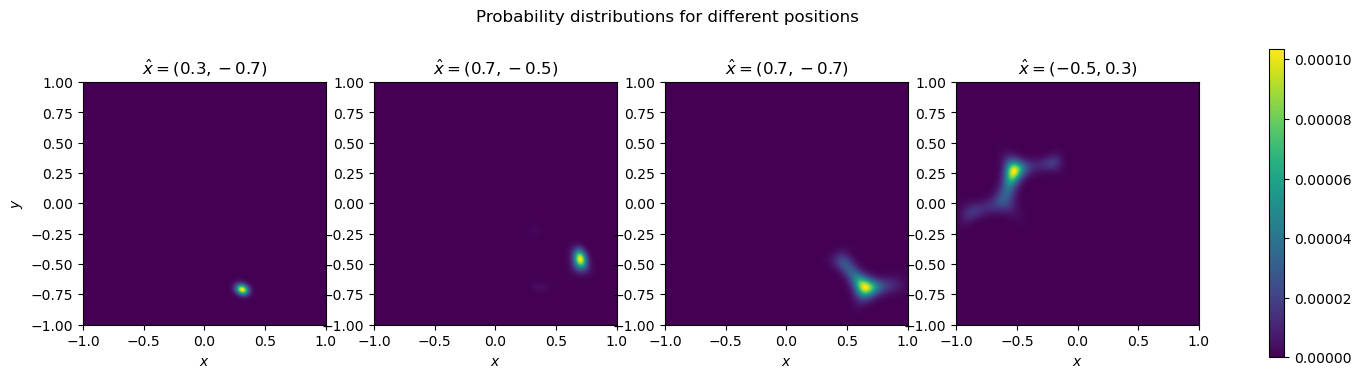

In [32]:
N = 1001
x_min, x_max = -1, 1
y_min, y_max = -1, 1

x_coords = torch.linspace(x_min, x_max, N, dtype=torch.float32, device=device)
y_coords = torch.linspace(y_min, y_max, N, dtype=torch.float32, device=device)

positions = torch.stack(torch.meshgrid(x_coords, y_coords, indexing="xy"), dim=-1)

true_x = torch.tensor([
    [ 0.3  ,  -0.7  ],
    [ 0.7,  -0.5],
    [ 0.7  ,  -0.7  ],
    [-0.5  , 0.3  ]
], dtype=torch.float32, device=device)

true_activations = grid_cell_array(true_x)
position_probabilities, position_expectations, _ = decoder(true_activations, positions)

print(position_expectations)

fig, axes = plt.subplots(ncols=true_x.shape[0], figsize=(true_x.shape[0] * 4 + 2, 4))

for i in range(true_x.shape[0]):
    im = axes[i].imshow(position_probabilities[i].reshape(N, N).detach().numpy(), origin="lower", extent=[x_min, x_max, y_min, y_max])
    axes[i].set_title(r"$\hat{{x}} = \left({:.1f}, {:.1f}\right)$".format(true_x[i, 0], true_x[i, 1]))
    axes[i].set_xlabel(r"$x$")
    if i == 0:
        axes[i].set_ylabel(r"$y$")
    axes[i].set_aspect("equal")

cbar = fig.colorbar(im, ax=axes.ravel().tolist())

plt.suptitle("Probability distributions for different positions", x=0.45)

plt.show();

In [33]:
# Interactive display
import ipywidgets as widgets

In [34]:
@widgets.interact(
    x=widgets.FloatSlider(0, min=-1.0, max=1.0),
    y=widgets.FloatSlider(0, min=-1.0, max=1.0),
)

def plot_position_estimate(x, y):
    true_x = torch.tensor([x, y], dtype=torch.float32, device=device)
    true_activations = grid_cell_array(true_x)
    position_probabilities, position_expectations, most_probable_positions = decoder(true_activations, positions)
    position_probabilities = position_probabilities.reshape(N, N).detach().numpy()
    position_expectations = position_expectations.detach().numpy()
    most_probable_positions = most_probable_positions.detach().numpy()

    plt.imshow(position_probabilities, origin="lower", extent=[x_min, x_max, y_min, y_max])
    plt.plot(x, y, marker="x", markersize=10, markeredgecolor="red", linestyle="None", label="True Position")
    plt.plot(position_expectations[0, 0], position_expectations[0, 1], marker="x", markersize=10, markeredgecolor="blue", linestyle ="None", label="Position Expectation")
    plt.plot(most_probable_positions[0, 0], most_probable_positions[0, 1], marker="x", markersize=10, markeredgecolor="yellow", linestyle="None", label="Most Probable Position")
    plt.title("Probability Distribution for $x_t = ({:.1f}, {:.1f})$".format(x, y))
    plt.colorbar()
    plt.legend()

interactive(children=(FloatSlider(value=0.0, description='x', max=1.0, min=-1.0), FloatSlider(value=0.0, descr…

In [35]:
decoder.weights()

Parameter containing:
tensor([ 1.3224, -2.3441, -2.3772,  3.4221,  1.2581,  2.6074,  2.6571, -1.5366,
         5.0907,  1.2607], requires_grad=True)

In [36]:
phi = torch.arange(0, 1, 0.01, dtype=torch.float32, device=device)
target_positions = torch.stack([0.9*torch.cos(2 * torch.pi * phi) ** 7, 0.9*torch.sin(2 * torch.pi * phi) ** 5], dim=1)

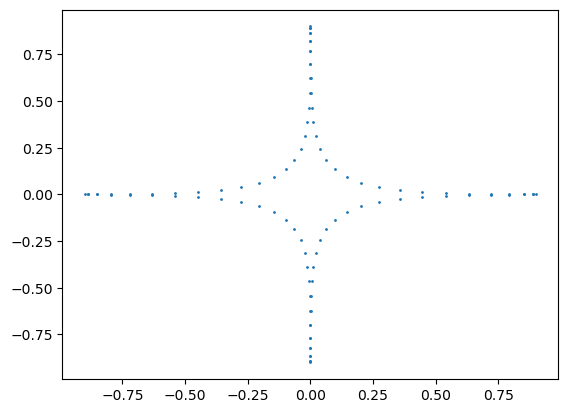

In [37]:
plt.scatter(target_positions.detach().numpy()[:, 0], target_positions.detach().numpy()[:, 1], s=1)

In [38]:
N = 1001
x_min, x_max = -1, 1
y_min, y_max = -1, 1

x_coords = torch.linspace(x_min, x_max, N, dtype=torch.float32, device=device)
y_coords = torch.linspace(y_min, y_max, N, dtype=torch.float32, device=device)

positions = torch.stack(torch.meshgrid(x_coords, y_coords, indexing="xy"), dim=-1)

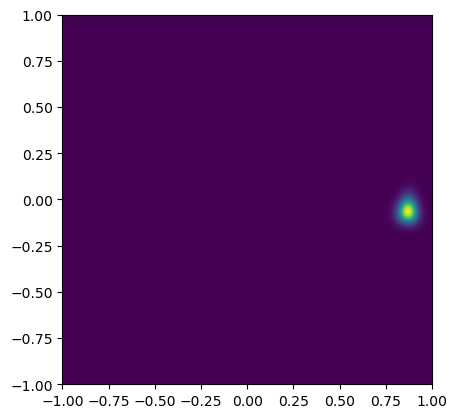

In [39]:
from matplotlib import animation

fig = plt.figure()
ax = fig.add_subplot(111)

def drawframe(n):
    x, y = target_positions[n]
    target_activations = grid_cell_array(target_positions[n])
    position_probabilities, position_expectations, most_probable_positions = decoder(target_activations, positions)
    position_probabilities = position_probabilities.reshape(N, N).detach().numpy()
    position_expectations = position_expectations.detach().numpy()
    most_probable_positions = most_probable_positions.detach().numpy()
    
    ax.clear()
    ax.imshow(position_probabilities, origin="lower", extent=[x_min, x_max, y_min, y_max])

    return ax,

anim = animation.FuncAnimation(fig, drawframe, frames=len(target_positions))

In [40]:
anim.save('../img/2d_crescent_positioning.gif', writer='imagemagick', fps=24)

In [41]:
from IPython.display import HTML
HTML(anim.to_html5_video())